**<font color=lightblue>PyTorch CNN on MNIST digits(input image is 28 x 28)</font>**

<img title="a title" alt="Alt text" src="mnist.png">

Train based on Two different CNN setups:
- Net1: zero-padding = 0, optimizer=SGD
- Net2: zero-padding = 2, optimizer=Adam

程式參考：PyTorch 官網範例，https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

參考卷積 convolution 的矩陣運算：http://www.songho.ca/dsp/convolution/convolution2d_example.html


![Convolution](https://i.stack.imgur.com/9OZKF.gif)

<font size = 3>[動畫來源](https://pub.towardsai.net/image-classification-with-neural-network-21a75cebb067)</font>

***<font color=khaki>Load and prepare data</font>***

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import pickle
import os
import numpy as np

# from scipy.io import loadmat
# mnist = loadmat("data/mnist-original.mat")
# X = mnist["data"].T # 70000 x 784
# y = mnist["label"][0]

data_file = r'D:\ys\B4_ShallowML\ShallowML\ClassData\mnist_digits_784.pkl'
# Check if data file exists
if os.path.isfile(data_file):
    # Load data from file
    with open(data_file, 'rb') as f:
        data = pickle.load(f)
else:
    # Fetch data from internet
    data = fetch_openml('mnist_784', version=1, parser='auto')
    # Save data to file
    with open(data_file, 'wb') as f:
        pickle.dump(data, f)

X, y = np.array(data.data), np.array(data.target).astype('int')


test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) # deafult test_size=0.25

# standaredize (may not be necessary)（因為影像處理有自己的標準化，所以 Z score 不適合）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()
X_train = X_train.reshape(-1, 1, 28, 28) # convert to N x 1 x 28 x 28 for CNN
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).long()
X_test = X_test.reshape(-1, 1, 28, 28) # N x 1 x 28 x 28

# check shapes of data
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

# create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


X_train.shape: torch.Size([56000, 1, 28, 28])
y_train.shape: torch.Size([56000])
X_test.shape: torch.Size([14000, 1, 28, 28])
y_test.shape: torch.Size([14000])


*<font color=khaki>Define the network</font>*

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 input channel, 6 output channels, 5x5 square convolution
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channel, 16 output channels, 5x5 square convolution
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4*4 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # 10 output classes

    def forward(self, x):
        
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # Max pooling over a (2, 2) window
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

net = Net().to(device)
print(net)

Using cpu device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


*<font color=blue>Use Torch Summary to see the details</font>*

In [5]:
from torchsummary import summary

summary(net, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
            Linear-3                  [-1, 120]          30,840
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.21
----------------------------------------------------------------


*<font color=khaki>Test to see the layer output for various settings</font>*

In [6]:
inData = torch.randn(128, 1, 28, 28) # sumulate 128 random 28 x 28 images with 1 channel

# layer 1
m = nn.Conv2d(1, 6, 5, stride=1, padding=0)
outData = m(inData)
print(outData.shape)
outData = F.max_pool2d(F.relu(outData), (2, 2))
print(outData.shape)

# layer 2
m = nn.Conv2d(6, 16, 5, stride=1)
outData = m(outData)
print(outData.shape)
outData = F.max_pool2d(F.relu(outData), 2)
print(outData.shape)

# start to enetr the NN part
outData = torch.flatten(outData, 1)
print(outData.shape)

m = nn.Linear(16 * 4 * 4, 120)
outData = m(outData)
print(outData.shape)

m = nn.Linear(120, 84)
outData = m(outData)
print(outData.shape)

m = nn.Linear(84, 10)
outData = m(outData)
print(outData.shape)
# check the output
print(outData[1,:])


torch.Size([128, 6, 24, 24])
torch.Size([128, 6, 12, 12])
torch.Size([128, 16, 8, 8])
torch.Size([128, 16, 4, 4])
torch.Size([128, 256])
torch.Size([128, 120])
torch.Size([128, 84])
torch.Size([128, 10])
tensor([-0.0762, -0.1585, -0.0709,  0.1820, -0.1138, -0.0288,  0.0477,  0.0008,
         0.0173,  0.0958], grad_fn=<SliceBackward0>)


*<font color=khaki>Take a look at the training image dataset</font>*

torch.Size([1, 28, 28])
tensor(4)
torch.Size([1, 28, 28])
(1, 10)
tensor([[-0.0614, -0.0517,  0.1202, -0.0413, -0.0085,  0.0566,  0.0021,  0.1098,
          0.0536,  0.1566]])
tensor([[9]])
[[-0.06136236 -0.05167704  0.12021585 -0.04127766 -0.00851816  0.05659489
   0.00213648  0.10978896  0.05360325  0.15657225]]


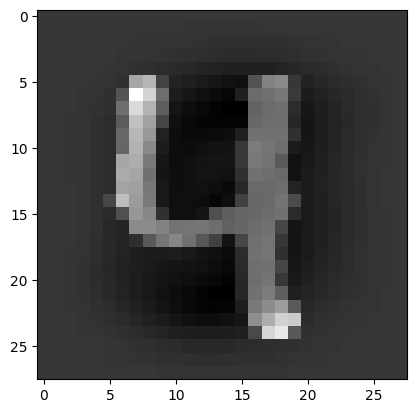

torch.Size([128, 1, 28, 28])


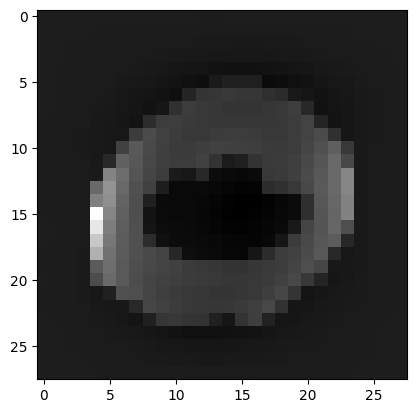

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2800663..46.68669].


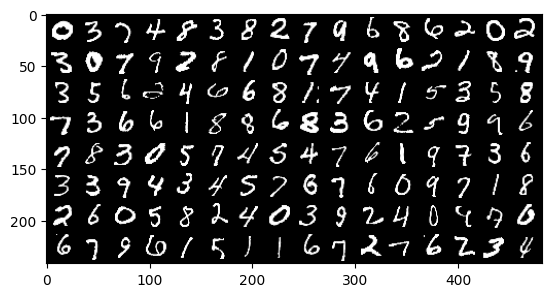

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

print(train_dataset[0][0].shape) # the shape of the first image
print(train_dataset[0][1]) # the label of the first image
print(X_train[0].shape) # the shape of the first image
inData = train_dataset[0][0].reshape(1, 1, 28, 28) # send the first image to the network
# inData = X_train[0].reshape(1, 1, 28, 28) # send the first image to the network
outData = net(inData.to(device))
print(outData.to("cpu").detach().numpy().shape) # the output shape of the first image
print(outData.data) # the output of the first image
print(outData.data.max(1, keepdim=True)[1]) # the position of the maximum value
print(outData.to("cpu").detach().numpy()) # convert the output to numpy array
# See the output of the first image
npimg = train_dataset[0][0] # the first image
plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray') # convert the image to numpy array and show it
plt.show()

# get some random training images
dataiter = iter(train_loader) # an iterable object
images, labels = next(dataiter) # get the next batch
print(images.shape) # the shape of the batch

# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (1, 2, 0))
plt.imshow(a_image_, cmap='gray')
plt.show()

# show a grid of images
montage = torchvision.utils.make_grid(images, nrow=16) # make a grid of images with 16 images per row
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
# writer.add_graph(net, images.to(device))
# writer.close()

*<font color=blue>Define a Loss function and optimizer</font>*

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net2.parameters(), lr = 0.01) 

*<font color=blue>Train the network</font>*

In [14]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()
epochs = 1
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device) # move to GPU if available
    
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs) # forward pass
        loss = criterion(outputs, labels) # compute loss
        # writer.add_scalar("Loss/train", loss, epoch)
        loss.backward() # compute gradients
        optimizer.step() # update weights

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[epoch : {epoch + 1}, batch: {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')
print(outputs.shape)
print(labels.shape)
# writer.flush()

[epoch : 1, batch:   200] loss: 2.290
[epoch : 1, batch:   400] loss: 2.219
Finished Training
torch.Size([64, 10])
torch.Size([64])


*<font color=blue>save our trained model for later use</font>*

做為再次訓練的起點或訓練完成後的使用狀態。

A .pth file in the context of PyTorch is a model checkpoint file that contains the learned weights of a trained neural network. The .pth extension stands for "PyTorch", indicating that the file is specifically meant to be loaded with PyTorch.

In [16]:
PATH = './digit10_net.pt' # .pth will collide with the PyTorch JIT
torch.save(net.state_dict(), PATH)

In [15]:
print(net.state_dict().keys())

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])


*<font color=blue>Test the network on the test data</font>*

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad(): # deactivate autograd engine
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1) # get the position of the maximum value
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct // total} %')

Accuracy of the network on the 14000 test images: 54 %


*<font color=blue>Test on a random batch</font>*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.273984..43.06403].


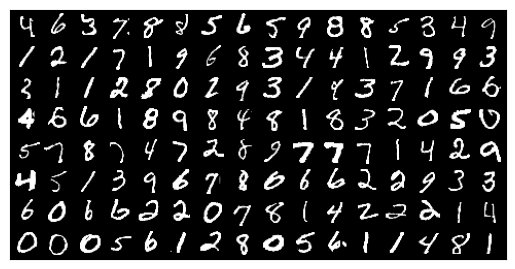

The predictions:
 {tensor([[4, 6, 7, 7, 4, 6, 6, 6, 7, 4, 4, 8, 8, 3, 4, 7],
        [8, 2, 1, 7, 1, 3, 6, 6, 2, 7, 4, 1, 2, 7, 4, 3],
        [8, 1, 1, 6, 6, 0, 6, 4, 3, 8, 1, 3, 7, 1, 0, 6],
        [6, 6, 2, 1, 6, 7, 1, 1, 3, 1, 4, 3, 2, 0, 2, 7],
        [8, 7, 8, 7, 1, 7, 6, 1, 3, 7, 7, 7, 1, 4, 6, 4],
        [0, 8, 1, 3, 9, 6, 7, 1, 0, 6, 6, 6, 2, 3, 3, 3],
        [6, 0, 6, 6, 6, 2, 0, 7, 4, 1, 4, 2, 0, 6, 1, 7],
        [0, 0, 0, 8, 6, 1, 6, 3, 0, 4, 6, 1, 6, 4, 7, 1]])}
Accuracy of the network on the 128 test images: 55.46875 %


In [18]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)

# print test images
nrow = 16 # number of images per row
montage = torchvision.utils.make_grid(images, nrow=nrow)
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.xticks([]) # remove x-axis ticks
plt.yticks([]) # remove y-axis ticks
plt.show()

# predict the labels
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // nrow, nrow)})

total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the {len(labels)} test images: {100 * correct_rate} %')


<hr>

**<font color=sjyblue>Train data by using Net2</font>**

Net2 is from https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

In [19]:
# Another way to define the network: borrow from https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10) # 32 * 7 * 7 is the size of the output of conv2
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1) # another way to flatten       
        output = self.out(x)
        return output, x    # return x for visualization

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

net2 = Net2().to(device)
print(net2)

Using cpu device
Net2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


*<font color=blue>Set up Loss function and optimizer</font>*

In [20]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net2.parameters(), lr = 0.01)

*<font color=blue>Start training</font>*

In [21]:
from torch.autograd import Variable # deprecated in PyTorch 0.4.0

num_epochs = 15
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders):
            
            # gives batch data, normalize x when iterate train_loader
            # b_x = Variable(images.to(device))   # batch x
            # b_y = Variable(labels.to(device))   # batch y
            b_x = images.to(device)   # batch x
            b_y = labels.to(device)   # batch y
            output = cnn(b_x)[0] # cnn output: get the first element of the returned tuple
                       
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 200 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                pass
        
        pass
    
    pass

train(num_epochs, net2, train_loader)

Epoch [1/15], Step [200/438], Loss: 0.1317
Epoch [1/15], Step [400/438], Loss: 0.1225
Epoch [2/15], Step [200/438], Loss: 0.0449
Epoch [2/15], Step [400/438], Loss: 0.0717
Epoch [3/15], Step [200/438], Loss: 0.0447
Epoch [3/15], Step [400/438], Loss: 0.0384
Epoch [4/15], Step [200/438], Loss: 0.0134
Epoch [4/15], Step [400/438], Loss: 0.0690
Epoch [5/15], Step [200/438], Loss: 0.0447
Epoch [5/15], Step [400/438], Loss: 0.0891
Epoch [6/15], Step [200/438], Loss: 0.0089
Epoch [6/15], Step [400/438], Loss: 0.1858
Epoch [7/15], Step [200/438], Loss: 0.0348
Epoch [7/15], Step [400/438], Loss: 0.0584
Epoch [8/15], Step [200/438], Loss: 0.0158
Epoch [8/15], Step [400/438], Loss: 0.0948
Epoch [9/15], Step [200/438], Loss: 0.0196
Epoch [9/15], Step [400/438], Loss: 0.0954
Epoch [10/15], Step [200/438], Loss: 0.0426
Epoch [10/15], Step [400/438], Loss: 0.0697
Epoch [11/15], Step [200/438], Loss: 0.1321
Epoch [11/15], Step [400/438], Loss: 0.0729
Epoch [12/15], Step [200/438], Loss: 0.0364
Epoch 

*<font color=blue>Evaluate the model on test data</font>*

In [23]:
def test():
    # Test the model
    net2.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            test_output, last_layer = net2(images.to(device))
            pred_y = torch.max(test_output, 1)[1]
            correct += (pred_y == labels.to(device)).sum().item()
            total += labels.size(0)
            # accuracy = (pred_y == labels.to(device)).sum().item() / float(labels.size(0))
            pass
    accuracy = correct / total
    print(f'Test Accuracy of the model on the {len(test_dataset)} test images: %.2f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 14000 test images: 0.98


*<font color=blue>Print 10 predictions from test data</font>*

In [24]:
sample = next(iter(test_loader))
imgs, lbls = sample
ground_truth = lbls[:10].numpy()
print("Ground truth:\n", ground_truth)

test_output, last_layer = net2(imgs[:10].to(device))
pred_y = torch.max(test_output, 1)[1]
# pred_y = torch.max(test_output, 1)[1].data.squeeze()
# print("Prediction:\n", pred_y)
print("Prediction:\n", pred_y.cpu().numpy())
# q: how to convert pred_y to numpy array?
# a: pred_y.cpu().numpy()


Ground truth:
 [4 3 7 6 5 2 2 1 8 9]
Prediction:
 [4 3 7 6 5 2 2 1 8 9]


In [25]:
a = torch.max(test_output, 1)
print(a[0])
print(a[1])
print(a[1].data)
print(a[1].data.squeeze())
print(a[1].data.squeeze().cpu())

tensor([27.7645, 11.0372, 10.5686, 26.6832,  7.9868, 24.7876, 28.6644, 20.2150,
        21.3706, 18.3613], grad_fn=<MaxBackward0>)
tensor([4, 3, 7, 6, 5, 2, 2, 1, 8, 9])
tensor([4, 3, 7, 6, 5, 2, 2, 1, 8, 9])
tensor([4, 3, 7, 6, 5, 2, 2, 1, 8, 9])
tensor([4, 3, 7, 6, 5, 2, 2, 1, 8, 9])
